In [2]:
%uv pip install -q datasets sentence_transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
import logging
import sys
import traceback
from datetime import datetime

from datasets import load_dataset

from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SequentialEvaluator, SimilarityFunction

model = SentenceTransformer("sbintuitions/sarashina-embedding-v2-1b")

# Set the log level to INFO to get more information
logging.basicConfig(format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO)

batch_size = 16
num_train_epochs = 4
matryoshka_dims = [1792, 1280, 768, 256, 64]

# Save path of the model
output_dir = f"output/sts_sarashina-embedding-v2-1b-{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# 1. Here we define our SentenceTransformer model. If not already a Sentence Transformer model, it will automatically
# create one with "mean" pooling.
# If we want, we can limit the maximum sequence length for the model
# model.max_seq_length = 75
logging.info(model)

2025-12-22 11:23:05 - SentenceTransformer(
  (0): Transformer({'max_seq_length': 8192, 'do_lower_case': False, 'architecture': 'LlamaModel'})
  (1): Pooling({'word_embedding_dimension': 1792, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': True, 'include_prompt': False})
)


In [4]:
train_dataset = load_dataset("mteb/JSTS", split="train")
eval_dataset = load_dataset("mteb/JSTS", split="validation")
logging.info(train_dataset)

# 3. Define our training loss
# similarity score column (between 0 and 1)
inner_train_loss = losses.MultipleNegativesRankingLoss(model=model)
train_loss = losses.MatryoshkaLoss(model, loss=inner_train_loss, matryoshka_dims=matryoshka_dims)

# 4. Define an evaluator for use during training. This is useful to keep track of alongside the evaluation loss.
evaluators = []
for dim in matryoshka_dims:
    evaluators.append(
        EmbeddingSimilarityEvaluator(
            sentences1=eval_dataset["sentence1"],
            sentences2=eval_dataset["sentence2"],
            scores=eval_dataset["score"],
            name=f"sts-dev-{dim}",
            truncate_dim=dim,
        )
    )
dev_evaluator = SequentialEvaluator(evaluators, main_score_function=lambda scores: scores[0])

2025-12-22 11:23:09 - Dataset({
    features: ['sentence1', 'sentence2', 'score'],
    num_rows: 12451
})


In [5]:
# 5. Define the training arguments
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir=output_dir,
    # Optional training parameters:
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    report_to="wandb",
    run_name="jsts-matryoshka",  # Will be used in W&B if `wandb` is installed
)

In [6]:
# 6. Create the trainer & start training
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=train_loss,
    evaluator=dev_evaluator,
)
trainer.train()

2025-12-22 11:23:15 - Detected kernel version 4.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: Currently logged in as: kushalfremont (kushalchat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.23.1
wandb: Run data is saved locally in /root/wandb/run-20251222_112316-nn5fud7f
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run jsts-matryoshka
wandb: ⭐️ View project at https://wandb.ai/kushalchat/sentence-transformers
wandb: 🚀 View run at https://wandb.ai/kushalchat/sentence-transformers/runs/nn5fud7f


Step,Training Loss,Validation Loss,Sts-dev-1792 Pearson Cosine,Sts-dev-1792 Spearman Cosine,Sts-dev-1280 Pearson Cosine,Sts-dev-1280 Spearman Cosine,Sts-dev-768 Pearson Cosine,Sts-dev-768 Spearman Cosine,Sts-dev-256 Pearson Cosine,Sts-dev-256 Spearman Cosine,Sts-dev-64 Pearson Cosine,Sts-dev-64 Spearman Cosine,Sequential Score
100,4.911000,6.237271,0.821580,0.757269,0.819777,0.757186,0.813960,0.751742,0.792065,0.735014,0.755674,0.711412,0.757269
200,5.866400,7.981264,0.705360,0.673894,0.698390,0.669200,0.689823,0.663604,0.662585,0.649960,0.588315,0.614568,0.673894
300,7.259000,7.982921,0.732853,0.683072,0.728134,0.681546,0.722817,0.679651,0.706879,0.669844,0.684672,0.652943,0.683072
400,7.123400,7.580994,0.732016,0.687797,0.731622,0.688675,0.726977,0.688140,0.713782,0.681937,0.693036,0.667883,0.687797
500,7.233000,6.938377,0.737558,0.662784,0.744913,0.669359,0.740328,0.665822,0.736667,0.666178,0.725816,0.658266,0.662784
600,7.022800,7.010242,0.725285,0.635152,0.724955,0.636382,0.721468,0.634589,0.716794,0.631028,0.705644,0.624589,0.635152
700,6.539000,6.767084,0.733619,0.641072,0.734368,0.641513,0.730548,0.640305,0.732741,0.639444,0.723350,0.634632,0.641072
800,6.286300,7.584608,0.694790,0.612005,0.724133,0.634157,0.720596,0.631384,0.718229,0.626594,0.706832,0.618886,0.612005
900,5.760800,6.747981,0.768397,0.677268,0.767084,0.679025,0.762922,0.675811,0.757134,0.674764,0.744785,0.669119,0.677268
1000,5.672000,6.648056,0.763205,0.684571,0.761713,0.683614,0.758045,0.681676,0.755999,0.683430,0.745300,0.679408,0.684571


2025-12-22 11:23:46 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-dev-1792 dataset in epoch 0.12836970474967907 after 100 steps (truncated to 1792):
2025-12-22 11:23:52 - Cosine-Similarity:	Pearson: 0.8216	Spearman: 0.7573
2025-12-22 11:23:52 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-dev-1280 dataset in epoch 0.12836970474967907 after 100 steps (truncated to 1280):
2025-12-22 11:23:57 - Cosine-Similarity:	Pearson: 0.8198	Spearman: 0.7572
2025-12-22 11:23:57 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-dev-768 dataset in epoch 0.12836970474967907 after 100 steps (truncated to 768):
2025-12-22 11:24:03 - Cosine-Similarity:	Pearson: 0.8140	Spearman: 0.7517
2025-12-22 11:24:03 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-dev-256 dataset in epoch 0.12836970474967907 after 100 steps (truncated to 256):
2025-12-22 11:24:09 - Cosine-Similarity:	Pearson: 0.7921	Spearman: 0.7350
2025-12-22 11:24:09 - EmbeddingSimilarit

TrainOutput(global_step=3116, training_loss=4.909690377035863, metrics={'train_runtime': 2224.0664, 'train_samples_per_second': 22.393, 'train_steps_per_second': 1.401, 'total_flos': 0.0, 'train_loss': 4.909690377035863, 'epoch': 4.0})

In [9]:
# 7. Evaluate the model performance on the STS Benchmark test dataset
test_dataset = load_dataset("mteb/JSTS", split="validation")
evaluators = []
for dim in matryoshka_dims:
    evaluators.append(
        EmbeddingSimilarityEvaluator(
            sentences1=test_dataset["sentence1"],
            sentences2=test_dataset["sentence2"],
            scores=test_dataset["score"],
            main_similarity=SimilarityFunction.COSINE,
            name=f"sts-test-{dim}",
            truncate_dim=dim,
        )
    )
test_evaluator = SequentialEvaluator(evaluators)
test_evaluator(model)

2025-12-22 12:04:50 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test-1792 dataset (truncated to 1792):
2025-12-22 12:04:56 - Cosine-Similarity:	Pearson: 0.8088	Spearman: 0.7435
2025-12-22 12:04:56 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test-1280 dataset (truncated to 1280):
2025-12-22 12:05:02 - Cosine-Similarity:	Pearson: 0.8078	Spearman: 0.7442
2025-12-22 12:05:02 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test-768 dataset (truncated to 768):
2025-12-22 12:05:08 - Cosine-Similarity:	Pearson: 0.8049	Spearman: 0.7423
2025-12-22 12:05:08 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test-256 dataset (truncated to 256):
2025-12-22 12:05:14 - Cosine-Similarity:	Pearson: 0.8022	Spearman: 0.7411
2025-12-22 12:05:14 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test-64 dataset (truncated to 64):
2025-12-22 12:05:20 - Cosine-Similarity:	Pearson: 0.7972	Spearman: 0.7389


{'sts-test-1792_pearson_cosine': 0.8087781664749797,
 'sts-test-1792_spearman_cosine': 0.7435051743546024,
 'sts-test-1280_pearson_cosine': 0.8078219018746986,
 'sts-test-1280_spearman_cosine': 0.7442250390777712,
 'sts-test-768_pearson_cosine': 0.8049404729865752,
 'sts-test-768_spearman_cosine': 0.7423149875969083,
 'sts-test-256_pearson_cosine': 0.8022025594051618,
 'sts-test-256_spearman_cosine': 0.7410686789846747,
 'sts-test-64_pearson_cosine': 0.7972183575514205,
 'sts-test-64_spearman_cosine': 0.7388646166416691,
 'sequential_score': 0.7388646166416691}

In [10]:
# 8. Save the trained & evaluated model locally
final_output_dir = f"{output_dir}/final"
model.save(final_output_dir)

model_name = "sarashina-embedding-v2-1b"
# 9. (Optional) save the model to the Hugging Face Hub!
# It is recommended to run `huggingface-cli login` to log into your Hugging Face account first
model_name = model_name if "/" not in model_name else model_name.split("/")[-1]
try:
    model.push_to_hub(f"{model_name}-jsts-matryoshka")
except Exception:
    logging.error(
        f"Error uploading model to the Hugging Face Hub:\n{traceback.format_exc()}To upload it manually, you can run "
        f"`huggingface-cli login`, followed by loading the model using `model = SentenceTransformer({final_output_dir!r})` "
        f"and saving it using `model.push_to_hub('{model_name}-jsts-matryoshka')`."
    )

2025-12-22 12:06:14 - Save model to output/sts_sarashina-embedding-v2-1b-2025-12-22_11-23-05/final
2025-12-22 12:06:21 - Save model to /tmp/tmpy2p260xk


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpy2p260xk/tokenizer.model      : 100%|##########| 1.83MB / 1.83MB            

  /tmp/tmpy2p260xk/model.safetensors    :   0%|          | 2.30MB / 4.90GB            

In [ ]:
!hf auth login --token # api key

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `kushalc` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `kushalc`


Evaluating models:   0%|          | 0/2 [00:00<?, ?it/s]

2025-12-22 12:42:34 - Use pytorch device_name: cuda:0
2025-12-22 12:42:34 - Load pretrained SentenceTransformer: kushalc1/sarashina-embedding-v2-1b-jsts-matryoshka


Evaluating kushalc1/sarashina-embedding-v2-1b-jsts-matryoshka:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-22 12:42:36 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:
2025-12-22 12:42:44 - Cosine-Similarity:	Pearson: 0.8088	Spearman: 0.7435
2025-12-22 12:42:44 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts-matryoshka/dim-1792


2025-12-22 12:42:51 - Cosine-Similarity:	Pearson: 0.8078	Spearman: 0.7442
2025-12-22 12:42:51 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts-matryoshka/dim-1280


2025-12-22 12:42:59 - Cosine-Similarity:	Pearson: 0.8049	Spearman: 0.7423
2025-12-22 12:42:59 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts-matryoshka/dim-768


2025-12-22 12:43:06 - Cosine-Similarity:	Pearson: 0.8022	Spearman: 0.7411
2025-12-22 12:43:06 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts-matryoshka/dim-256


2025-12-22 12:43:14 - Cosine-Similarity:	Pearson: 0.7972	Spearman: 0.7389
2025-12-22 12:43:14 - Use pytorch device_name: cuda:0
2025-12-22 12:43:14 - Load pretrained SentenceTransformer: kushalc1/sarashina-embedding-v2-1b-jsts


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts-matryoshka/dim-64


Evaluating kushalc1/sarashina-embedding-v2-1b-jsts:   0%|          | 0/5 [00:00<?, ?it/s]

2025-12-22 12:43:16 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:
2025-12-22 12:43:24 - Cosine-Similarity:	Pearson: 0.8124	Spearman: 0.7521
2025-12-22 12:43:24 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts/dim-1792


2025-12-22 12:43:31 - Cosine-Similarity:	Pearson: 0.8099	Spearman: 0.7491
2025-12-22 12:43:31 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts/dim-1280


2025-12-22 12:43:39 - Cosine-Similarity:	Pearson: 0.8057	Spearman: 0.7461
2025-12-22 12:43:39 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts/dim-768


2025-12-22 12:43:46 - Cosine-Similarity:	Pearson: 0.7945	Spearman: 0.7380
2025-12-22 12:43:46 - EmbeddingSimilarityEvaluator: Evaluating the model on the sts-test dataset:


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts/dim-256


2025-12-22 12:43:54 - Cosine-Similarity:	Pearson: 0.7531	Spearman: 0.7080


Saved results to kushalc1_sarashina-embedding-v2-1b-jsts/dim-64
{'kushalc1/sarashina-embedding-v2-1b-jsts-matryoshka': {1792: 0.7435029791344707, 1280: 0.7442111119172904, 768: 0.742317131751736, 256: 0.741064557781238, 64: 0.7388701945025029}, 'kushalc1/sarashina-embedding-v2-1b-jsts': {1792: 0.7520669873625399, 1280: 0.7491157586955496, 768: 0.7460916709221981, 256: 0.7380258237503533, 64: 0.7080030403748029}}
{64: 0.7388701945025029, 256: 0.741064557781238, 768: 0.742317131751736, 1280: 0.7442111119172904, 1792: 0.7435029791344707}
{64: 0.7080030403748029, 256: 0.7380258237503533, 768: 0.7460916709221981, 1280: 0.7491157586955496, 1792: 0.7520669873625399}


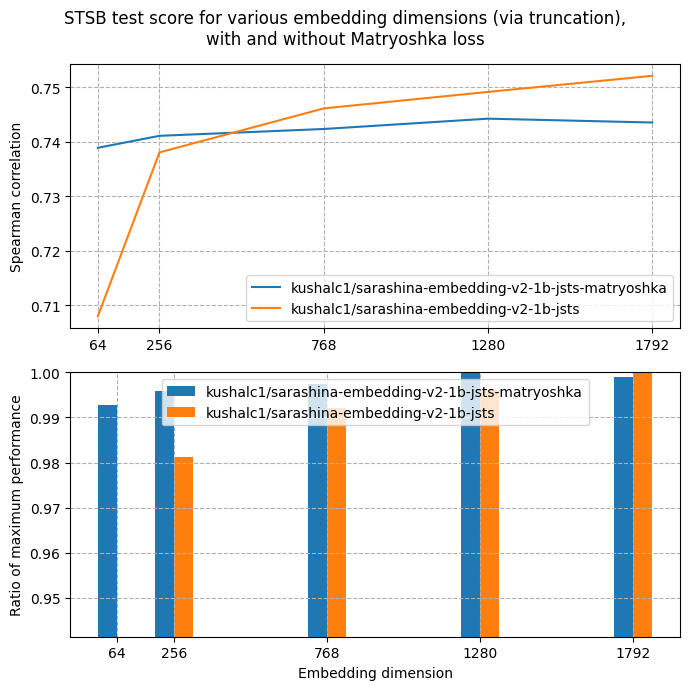

In [30]:
"""
This script evaluates embedding models truncated at different dimensions on the STS
benchmark.
"""

import argparse
import os
from typing import Optional, cast

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tqdm.auto import tqdm

from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction


# Dimension plot
def _grouped_barplot_ratios(group_name_to_x_to_y: dict[str, dict[int, float]], ax: Optional[plt.Axes] = None) -> plt.Axes:
    if ax is None:
        fig, ax = plt.subplots()
    # Sort each by x
    group_name_to_x_to_y = {
        group_name: dict(sorted(x_to_y.items(), key=lambda x: x[0]))
        for group_name, x_to_y in group_name_to_x_to_y.items()
    }
    # Check that all x are the same
    xticks = None
    for group_name, x_to_y in group_name_to_x_to_y.items():
        _xticks = x_to_y.keys()
        if xticks is not None and _xticks != xticks:
            raise ValueError(f"{group_name} has different keys: {_xticks}")
        xticks = _xticks
    xticks = sorted(xticks)

    group_name_to_max_y = {group_name: max(x_to_y.values()) for group_name, x_to_y in group_name_to_x_to_y.items()}
    num_groups = len(group_name_to_x_to_y)
    bar_width = np.diff(xticks).min() / (num_groups + 1) if len(xticks) > 1 else 0.1

    xs = np.array([
        np.linspace(
            start=xtick - ((bar_width / 2) * (num_groups - 1)),
            stop=xtick + ((bar_width / 2) * (num_groups - 1)),
            num=num_groups,
        )
        for xtick in xticks
    ]).T

    min_ratio = np.inf
    for i, (group_name, x_to_y) in enumerate(group_name_to_x_to_y.items()):
        max_y = group_name_to_max_y[group_name]
        ys = [y / max_y for y in x_to_y.values()]
        min_ratio = min(min_ratio, min(ys))
        ax.bar(xs[i], ys, bar_width, label=group_name)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    ax.grid(linestyle="--")
    ax.set_ylim(min(0.95, min_ratio), 1)
    ax.legend()
    return ax


def plot_across_dimensions(
    model_name_to_dim_to_score: dict[str, dict[int, float]],
    filename: str,
    figsize: tuple[float, float] = (7, 7),
    title: str = "STSB test score for various embedding dimensions (via truncation),\nwith and without Matryoshka loss",
) -> None:
    model_name_to_dim_to_score = {
        model_name: dict(sorted(dim_to_score.items(), key=lambda x: x[0]))
        for model_name, dim_to_score in model_name_to_dim_to_score.items()
    }
    xticks = sorted(list(model_name_to_dim_to_score.values())[0].keys())

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    ax1 = cast(plt.Axes, ax1)
    ax2 = cast(plt.Axes, ax2)

    # Line plot
    for model_name, dim_to_score in model_name_to_dim_to_score.items():
        print(dim_to_score)
        ax1.plot(dim_to_score.keys(), dim_to_score.values(), label=model_name)
    ax1.set_xticks(xticks)
    ax1.set_ylabel("Spearman correlation")
    ax1.grid(linestyle="--")
    ax1.legend()

    # Bar plot
    ax2 = _grouped_barplot_ratios(model_name_to_dim_to_score, ax=ax2)
    ax2.set_xlabel("Embedding dimension")
    ax2.set_ylabel("Ratio of maximum performance")

    fig.suptitle(title)
    fig.tight_layout()
    fig.savefig(filename)


DEFAULT_MODEL_NAMES = [
    "kushalc1/sarashina-embedding-v2-1b-jsts-matryoshka",  # fit using Matryoshka loss
    "kushalc1/sarashina-embedding-v2-1b-jsts",  # baseline
]
DEFAULT_DIMENSIONS = [1792, 1280, 768, 256, 64]

plot_filename: str = 'stsb_dim_plot.png'
model_names: list[str] = DEFAULT_MODEL_NAMES
DIMENSIONS: list[int] = DEFAULT_DIMENSIONS

stsb_test = load_dataset("mteb/JSTS", split="validation")
test_evaluator = EmbeddingSimilarityEvaluator(
    stsb_test["sentence1"],
    stsb_test["sentence2"],
    [score / 5 for score in stsb_test["score"]],
    main_similarity=SimilarityFunction.COSINE,
    name="sts-test",
)

model_name_to_dim_to_score: dict[str, dict[int, float]] = {}
for model_name in tqdm(model_names, desc="Evaluating models"):
    model = SentenceTransformer(model_name)
    dim_to_score = {}
    for dim in tqdm(DIMENSIONS, desc=f"Evaluating {model_name}"):
        output_path = os.path.join(model_name.replace("/", "_"), f"dim-{dim}")
        os.makedirs(output_path, exist_ok=True)

        # Truncate embeddings via monkey-patching
        original_encode = model.encode

        def truncated_encode(sentences, **kwargs):
            embeddings = original_encode(sentences, **kwargs)
            return embeddings[:, :dim]

        model.encode = truncated_encode

        score = test_evaluator(model, output_path=output_path)
        print(f"Saved results to {output_path}")
        dim_to_score[dim] = score['sts-test_spearman_cosine']

        # Restore original encode
        model.encode = original_encode

    model_name_to_dim_to_score[model_name] = dim_to_score

print(model_name_to_dim_to_score)

plot_across_dimensions(model_name_to_dim_to_score, plot_filename)